notebook runnable in colab

In [1]:
!git clone https://github.com/sosamandara/token_reduction_nlp.git

Cloning into 'token_reduction_nlp'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 60 (delta 21), reused 44 (delta 11), pack-reused 0
Receiving objects: 100% (60/60), 315.38 KiB | 7.01 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
%cd /content/token_reduction_nlp

/content/token_reduction_nlp


# Time and Flops

In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Assuming the notebooks are in the notebooks directory and executed from there
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the models and src directories to the Python path
models_dir = os.path.join(project_root, 'models')
src_dir = os.path.join(project_root, 'src')

sys.path.append(models_dir)
sys.path.append(src_dir)

# Verify that the paths are correctly added
print("Current directory:", current_dir)
print("Project root directory:", project_root)
print("Models directory added to sys.path:", models_dir in sys.path)
print("Src directory added to sys.path:", src_dir in sys.path)

Current directory: d:\TESI\token_reduction_nlp\notebooks
Project root directory: d:\TESI\token_reduction_nlp
Models directory added to sys.path: True
Src directory added to sys.path: True


In [2]:
!pip install datasets
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModel
from modeling_topK_gpt2 import CustomGPT2LMHeadModel
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from datasets import load_dataset
from functions import run_generation_on_dataset, plot_averages
from perplexity import evaluate_perplexity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd

In [3]:
dataset = load_dataset("ag_news")
dataset

Found cached dataset parquet (C:/Users/Angelo/.cache/huggingface/datasets/parquet/ag_news-f4012edcb412d6fa/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

# Run and save the files

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name, config=config)
model_gpt.to('cuda')

results_gpt = run_generation_on_dataset(dataset, model_gpt, tokenizer, 50, [10, 20, 30, 50, 100, 200, 300], "custom_model_50_with_flops")

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
custom_model = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=[0.0, 0.0, 0.2, 0.2, 0.2, 0.15, 0.2, 0.2, 0.05, 0.05, 0.0, 0.05],
                                                     layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
custom_model.to('cuda')

results_custom = run_generation_on_dataset(dataset, custom_model, tokenizer, 50, [10, 20, 30, 50, 100, 200, 300], "model_gpt_2_50_with_flops")

# Obtain metrics

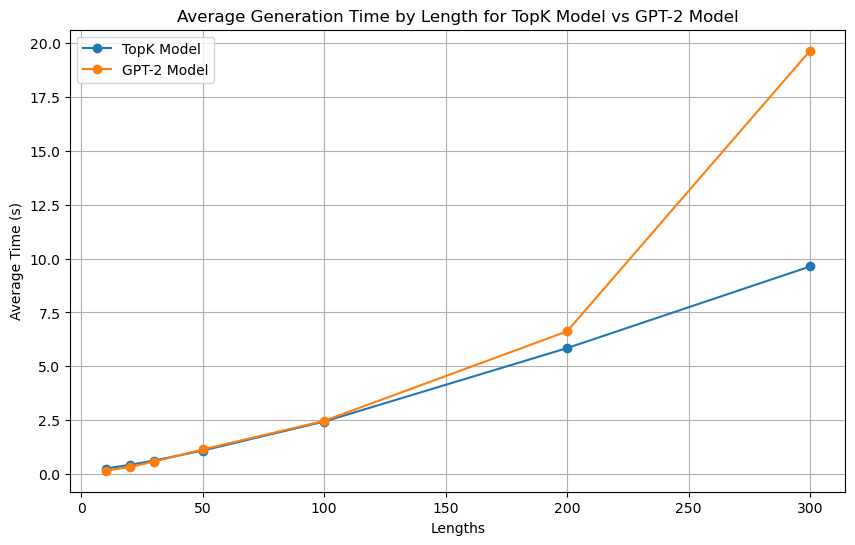

In [9]:
# Construct the paths to the JSON files
project_root = os.path.abspath(os.path.join(current_dir, '..'))
results_dir = os.path.join(project_root, 'results')

custom_model_path = os.path.join(results_dir, 'generation_results_custom_model_50_with_flops.json')
gpt2_model_path = os.path.join(results_dir, 'generation_results_model_gpt_2_50_with_flops.json')

# Load the results from JSON files
with open(custom_model_path, 'r') as f:
    custom_model_results = json.load(f)

with open(gpt2_model_path, 'r') as f:
    gpt2_model_results = json.load(f)

figsize = (10, 6)

# plot average times
plot_averages(custom_model_results, gpt2_model_results, key="time_taken", ylabel='Average Time (s)', title='Average Generation Time by Length for TopK Model vs GPT-2 Model', figsize=figsize)

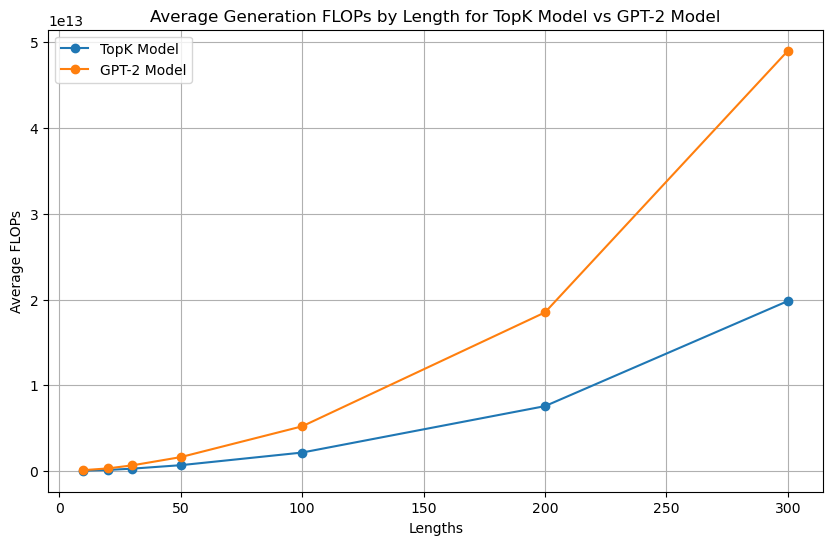

In [10]:
# plot average FLOPs
plot_averages(custom_model_results, gpt2_model_results, key="flops", ylabel='Average FLOPs', title='Average Generation FLOPs by Length for TopK Model vs GPT-2 Model', figsize=figsize)

# BertScore

In [11]:
# initialize BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().numpy()

gpt2_generated_embeddings = []
custom_generated_embeddings = []

for result in gpt2_model_results:
    generated_text = result['generated_text']
    embedding = get_bert_embeddings(generated_text)
    gpt2_generated_embeddings.append(embedding)

for result in custom_model_results:
    generated_text = result['generated_text']
    embedding = get_bert_embeddings(generated_text)
    custom_generated_embeddings.append(embedding)

gpt2_generated_embeddings = np.vstack(gpt2_generated_embeddings)
custom_generated_embeddings = np.vstack(custom_generated_embeddings)

similarities = []

for gpt2_emb, custom_emb in zip(gpt2_generated_embeddings, custom_generated_embeddings):
    similarity = cosine_similarity([gpt2_emb], [custom_emb]).mean()
    similarities.append(similarity)

average_similarity = np.mean(similarities)
average_similarity

0.76342946

# bert_score

In [ ]:
!pip install transformers torch bert_score

In [ ]:
from bert_score import score

gpt2_generated_texts = [result['generated_text'] for result in gpt2_model_results]
custom_generated_texts = [result['generated_text'] for result in custom_model_results]

# BERTScore
P, R, F1 = score(gpt2_generated_texts, custom_generated_texts, lang="en", verbose=True)

# average BERTScores
average_precision = P.mean().item()
average_recall = R.mean().item()
average_f1 = F1.mean().item()

print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1: {average_f1}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/11 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/6 [00:00<?, ?it/s]

done in 26.93 seconds, 13.00 sentences/sec
Average Precision: 0.8391859531402588
Average Recall: 0.8304443359375
Average F1: 0.8344979286193848


# ROGUE Score

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

gpt2_texts = [result['generated_text'] for result in gpt2_model_results]
custom_texts = [result['generated_text'] for result in custom_model_results]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# compute ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for gpt2_text, custom_text in zip(gpt2_texts, custom_texts):
    scores = scorer.score(gpt2_text, custom_text)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# average ROUGE scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average ROUGE-1 Score:", round(average_rouge1,2))
print("Average ROUGE-2 Score:", round(average_rouge2,2))
print("Average ROUGE-L Score:", round(average_rougeL,2))

Average ROUGE-1 Score: 0.3
Average ROUGE-2 Score: 0.14
Average ROUGE-L Score: 0.27


In [ ]:
# Load the datasets
with open(gpt2_model_path, 'r') as f:
    gpt2_results = json.load(f)

with open(custom_model_path, 'r') as f:
    custom_results = json.load(f)

# Filter out results with lengths 100, 200, and 300
filtered_gpt2_results = [result for result in gpt2_results if result['lengths'] not in [50,100, 200, 300]]
filtered_custom_results = [result for result in custom_results if result['lengths'] not in [50,100, 200, 300]]

# Extract generated texts from the filtered results
filtered_gpt2_texts = [result['generated_text'] for result in filtered_gpt2_results]
filtered_custom_texts = [result['generated_text'] for result in filtered_custom_results]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for gpt2_text, custom_text in zip(filtered_gpt2_texts, filtered_custom_texts):
    scores = scorer.score(gpt2_text, custom_text)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average ROUGE-1 Score:", round(average_rouge1,2))
print("Average ROUGE-2 Score:", round(average_rouge2,2))
print("Average ROUGE-L Score:", round(average_rougeL,2))

Average ROUGE-1 Score: 0.36
Average ROUGE-2 Score: 0.2
Average ROUGE-L Score: 0.34


# Perplexity

Reference: https://huggingface.co/docs/transformers/perplexity

In [110]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [ ]:
log_probs_gpt2 = evaluate_perplexity(model_gpt, encodings, 20)
# Calculate final perplexity
avg_log_prob_gpt2 = np.mean(log_probs_gpt2)
perplexity_gpt2 = np.exp(-avg_log_prob_gpt2)

print("Final Perplexity:", perplexity_gpt2)

In [127]:
perplexity_gpt2

33.47348659116395

In [125]:
df = pd.DataFrame(log_probs_gpt2, columns=["log_prob"])

# Save to CSV
file_path = "results/log_probs_gpt2.csv"
df.to_csv(file_path, index=False)

In [ ]:
log_probs_topK = evaluate_perplexity(custom_model, encodings, 20)
# Calculate final perplexity
avg_log_probs_topK = np.mean(log_probs_topK)
perplexity_topK = np.exp(-avg_log_probs_topK)

print("Final Perplexity:", perplexity_topK)

In [126]:
perplexity_topK

48.890736229323025

In [123]:
df = pd.DataFrame(log_probs_topK, columns=["log_prob"])

# Save to CSV
file_path = "results/log_probs_topK.csv"
df.to_csv(file_path, index=False)